Вариант 5. Стохастический градиентный бустинг с RSM

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import ctypes

from numpy import uint32
from numpy.ctypeslib import ndpointer
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from scipy.optimize import minimize_scalar
from sklearn.ensemble import GradientBoostingRegressor
import matplotlib.pyplot as plt 
import math
from numpy.random import default_rng
import re
import warnings
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
import math
from numpy.random import default_rng
from tqdm import tqdm
rng = default_rng()
warnings.filterwarnings("ignore")

In [2]:
lib = ctypes.cdll.LoadLibrary('./liba.so')
pred1 = lib.simple_function
pred1.argtypes = [ndpointer(ctypes.c_float, flags='C_CONTIGUOUS'),ctypes.c_int,\
ctypes.c_int,ndpointer(ctypes.c_int, flags='C_CONTIGUOUS'),\
ndpointer(ctypes.c_float, flags='C_CONTIGUOUS'),ndpointer(ctypes.c_float, flags='C_CONTIGUOUS'),\
ndpointer(ctypes.c_int, flags='C_CONTIGUOUS'),ndpointer(ctypes.c_float, flags='C_CONTIGUOUS'),\
ndpointer(ctypes.c_int, flags='C_CONTIGUOUS')]
pred1.restype = ctypes.c_int


In [3]:
lib = ctypes.cdll.LoadLibrary('./liba.so')
pred_boost = lib.boost_pred
pred_boost.argtypes = [ndpointer(ctypes.c_float, flags='C_CONTIGUOUS'),ctypes.c_int,\
ctypes.c_int,ctypes.c_int,ctypes.c_int,ndpointer(ctypes.c_int, flags='C_CONTIGUOUS'),\
ndpointer(ctypes.c_float, flags='C_CONTIGUOUS'),ndpointer(ctypes.c_float, flags='C_CONTIGUOUS'),\
ndpointer(ctypes.c_int, flags='C_CONTIGUOUS'),ndpointer(ctypes.c_float, flags='C_CONTIGUOUS'),\
ndpointer(ctypes.c_float, flags='C_CONTIGUOUS'), ndpointer(ctypes.c_int, flags='C_CONTIGUOUS'), ctypes.c_int]
pred_boost.restype = ctypes.c_int

In [4]:
lib = ctypes.cdll.LoadLibrary('./tree.so')
fit_tree = lib.fit
fit_tree.argtypes = [ndpointer(ctypes.c_double, flags='C_CONTIGUOUS'),\
ndpointer(ctypes.c_double, flags='C_CONTIGUOUS'),ctypes.c_int, ctypes.c_int,\
ctypes.c_int, ctypes.c_int, ctypes.c_int,ndpointer(ctypes.c_float, flags='C_CONTIGUOUS'),\
ctypes.c_int]

fit_tree.restype = None

In [5]:
class GradientBoostingRegressorMy:
    def __init__(self, max_depth: int=3, n_estimators: int=100, min_samples_split: int=2,
                learning_rate: float=0.1, max_features=None, subsample = 1.0, min_samples_leaf = 1,
                feature_percent = 1.0):
        self.max_depth = max_depth
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.feature_percent = feature_percent
        self.learning_rate = learning_rate
        self.max_features = max_features
        self.n_estimators = n_estimators
        self.weights = []
        self.features = []
        self.subsample = subsample
    def set_params(self, **params):
        self.max_depth = params.get("depth", 3)
        self.learning_rate = params.get("learning_rate", 0.1)
        self.n_estimators = params.get("n_estimators", 20)
        self.first_model_type = params.get("first_model_type", "RF")
        self.rf_n_estimators = params.get("rf_n_estimators", 20)
        self.min_samples_split = params.get("min_samples_split", 2)
        self.max_features = params.get("max_features")
        return self
        
    def get_params(self, deep=True):
        return {
            "max_depth": self.max_depth,
            "n_estimators": self.n_estimators,
            "min_samples_split": self.min_samples_split,
            "learning_rate": self.learning_rate,
            "max_features": self.max_features
        }
    

    
    def fit(self, X, y):
      
        size_subset = int(X.shape[0] * self.subsample)
        self.feature_subset = int(X.shape[1] * self.feature_percent)

        a = np.zeros(X.shape[0])
        self.mean = np.mean(y)
        a += np.mean(y)
        X_ind = np.random.choice(X.shape[0], size_subset, replace = False)
        feature_ind = np.random.choice(X.shape[1], self.feature_subset, replace = False)
    
        self.tree_size = (3, 2 ** (self.max_depth + 1))
        tree = np.zeros(shape=self.tree_size, dtype = np.float32)
        X_c = X[X_ind,:][:,feature_ind].T.copy(order ='C').astype(np.float64)
        y_c = (y - a)[X_ind].copy(order ='C').astype(np.float64)
       
        fit_tree(X_c,\
        y_c ,feature_ind.shape[0],X_ind.shape[0], 
        self.min_samples_split, self.min_samples_leaf, self.max_depth, tree, tree.shape[1])
        b = np.zeros(X.shape[0], dtype = np.float32)
        
        pred1(X.astype(np.float32), X.shape[0],X.shape[1],\
        tree[1].astype(np.int32),\
        tree[2], tree[1],\
        tree[0].astype(np.int32),b,feature_ind.astype(np.int32)) 
        
        #w = np.sum(b * (y - a)) / np.sum(b ** 2)
        w = 1 #sklearn
        self.features = np.array(feature_ind, dtype = np.int32)
        self.weights.append(self.learning_rate * w)
        a +=  self.learning_rate * w * b
        self.fin = tree

        for i in range(1, self.n_estimators):
            X_ind = np.random.choice(X.shape[0], size_subset, replace = False)
            feature_ind = np.random.choice(X.shape[1], self.feature_subset, replace = False)
            tree = np.zeros(shape=self.tree_size, dtype = np.float32)
            X_c = X[X_ind,:][:,feature_ind].T.copy(order ='C')
            y_c = (y - a)[X_ind].copy(order ='C') 

            fit_tree(X_c,\
            y_c ,feature_ind.shape[0],X_ind.shape[0], 
            self.min_samples_split, self.min_samples_leaf, self.max_depth, tree, tree.shape[1])
            b = np.zeros(X.shape[0], dtype = np.float32)
            
            pred1(X.astype(np.float32), X.shape[0],X.shape[1],\
            tree[1].astype(np.int32),\
            tree[2], tree[1],\
            tree[0].astype(np.int32),b,feature_ind.astype(np.int32)) 
            
            # = np.sum(b * (y - a)) / np.sum(b ** 2)
           # w = 1 #sklearn
            self.features =  np.vstack((self.features, feature_ind))
            self.weights.append(self.learning_rate * w)
            a +=  self.learning_rate * w * b
            self.fin = np.hstack((self.fin,tree))
        self.new_fin = np.copy(self.fin, order = 'C').astype(np.float32)

    def predict(self, X):
        answ = np.zeros(X.shape[0], dtype = np.float32)
        answ += self.mean
        pred_boost(X.astype(np.float32),\
                   X.shape[0],X.shape[1],self.n_estimators,self.tree_size[1],\
                   self.new_fin[1].astype(np.int32),self.new_fin[2],self.new_fin[1],\
                         self.new_fin[0].astype(np.int32),\
                         np.array(self.weights, dtype = np.float32),answ,\
                         self.features.astype(np.int32),\
                         self.feature_subset,)
        return answ
   
    def staged_predict(self, X, y, step):
        for i in range(1, self.n_estimators + 1, step):
            answ = np.zeros(X.shape[0], dtype = np.float32)
            answ += self.mean
            pred_boost(X.astype(np.float32),\
                   X.shape[0],X.shape[1],i,self.tree_size[1],\
                   self.new_fin[1].astype(np.int32),self.new_fin[2],self.new_fin[1],\
                         self.new_fin[0].astype(np.int32),\
                         np.array(self.weights, dtype = np.float32),answ,\
                         self.features.astype(np.int32),\
                         self.feature_subset,)
            yield mean_squared_error(answ, y)

In [6]:
def create_plot_MSE(X_train, y_train, X_test, y_test, max_models, depth, step = 1, subsample = 1.0, feature_percent = 1.0):
    my_er = []
    his_er = []
    his_er_low = []
    his_er_high = []
    my_bus = GradientBoostingRegressorMy(n_estimators = max_models, max_depth = depth,
            subsample = subsample, feature_percent = feature_percent)
    his_bus = GradientBoostingRegressor(n_estimators = max_models,
            max_depth = depth, criterion = 'mse', subsample = subsample)
    my_bus.fit(X_train, y_train)
    his_bus.fit(X_train, y_train)
    cur_step = 0
    steps = []
    for it in my_bus.staged_predict(X_test, y_test, step):
        my_er.append(it)
        cur_step += step
        steps.append(cur_step)
    for it in list(his_bus.staged_predict(X_test))[::step]:
        his_er.append(mean_squared_error(it, y_test))
        his_er_low.append(mean_squared_error(it, y_test) * 0.97)
        his_er_high.append(mean_squared_error(it, y_test) * 1.03)

    fig = plt.figure(figsize= (14,5))
    ax = fig.add_subplot(111)
    ax.set_xlabel('Number of estimators')
    ax.set_ylabel('MSE loss')
    ax.plot(steps,his_er, label = "Sklearn boosting error",color = 'blue', linestyle = (0, (5, 10)))
    ax.plot(steps, my_er,label = "My boosting error",color = 'green')
    ax.plot(steps,his_er_low, label = "Low 3% Sklearn boosting error",color = 'r')
    ax.plot(steps,his_er_high, label = "High 3% Sklearn boosting error", color ='r')
    ax.legend(loc = 'best')
    plt.show()

In [7]:
with open("reg.test.txt") as fin:
    data = []
    label = [] 
    for every in fin:
        buf = every.split()
        label.append(float(buf[0]))
        features = np.array([np.nan]*245)
        for p in buf[1:-1]:
            a, b = p.split(':')
            a, b = int(a), float(b)
            features[a] = b
        data.append(features[1:])

X_test = np.array(data)
y_test = np.array(label)
with open("reg.train.txt") as fin:
    data = []
    label = [] 
    for every in fin:
        buf = every.split()
        label.append(float(buf[0]))
        features = np.array([np.nan]*245)
        for p in buf[1:-1]:
            a, b = p.split(':')
            a, b = int(a), float(b)
            features[a] = b
        data.append(features[1:])

X_train = np.array(data)
y_train = np.array(label)
for i in range(X_train.shape[1]):
    if  np.isnan(np.mean(X_train[~np.isnan(X_train[:,i]), i])):
        X_train[:, i] = 0
        continue
    X_train[np.isnan(X_train[:,i]), i] = np.median(X_train[~np.isnan(X_train[:,i]), i])
for i in range(X_test.shape[1]):
    if  np.isnan(np.mean(X_test[~np.isnan(X_test[:,i]), i])):
        X_test[:, i] = 0
        continue
    X_test[np.isnan(X_test[:,i]), i] = np.median(X_test[~np.isnan(X_test[:,i]), i])

Сначала сравним бустинги без стохастичности

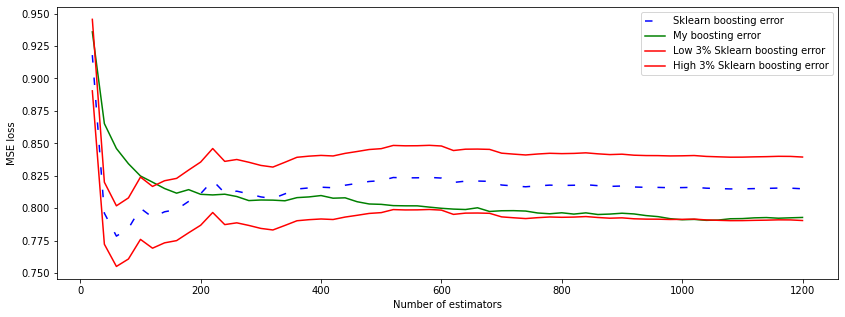

In [14]:
create_plot_MSE(X_train,y_train,X_test,y_test, 1200, 6, step = 20)

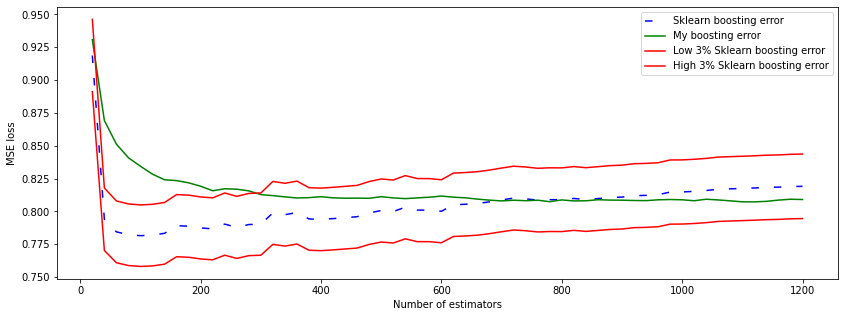

In [10]:
create_plot_MSE(X_train,y_train,X_test,y_test, 1200, 4, step = 20)

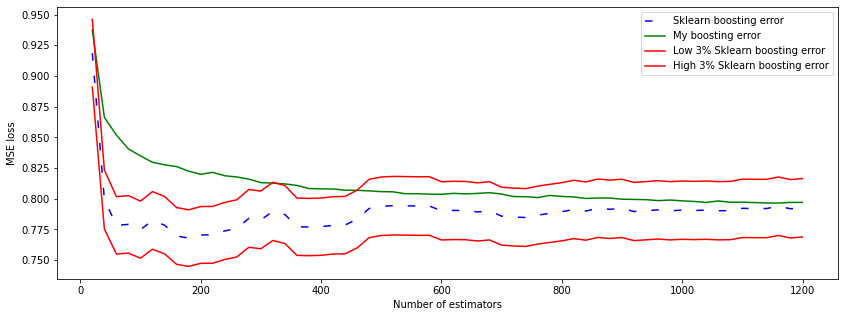

In [11]:
create_plot_MSE(X_train,y_train,X_test,y_test, 1200, 5, step = 20)

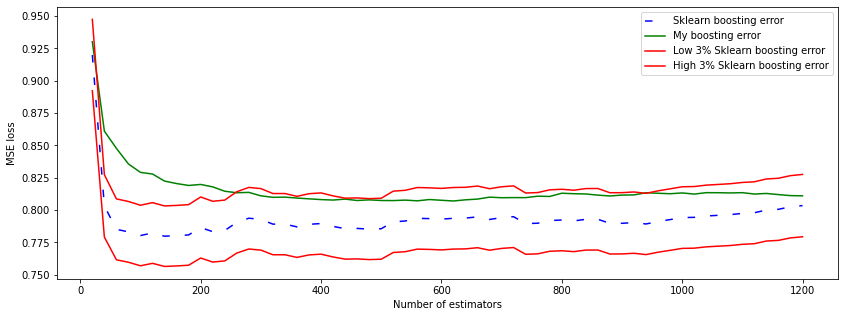

In [12]:
create_plot_MSE(X_train,y_train,X_test,y_test, 1200, 3, step = 20)

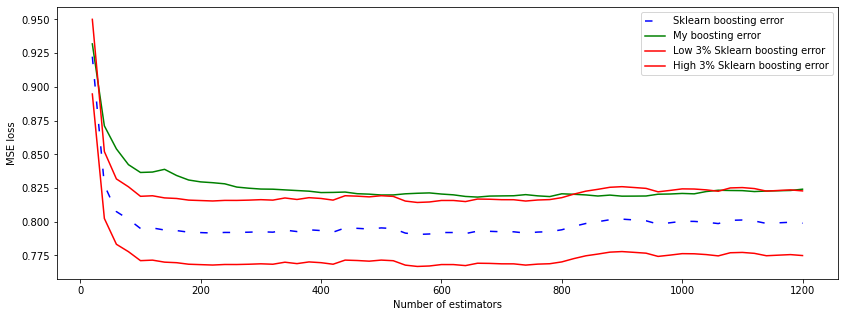

In [13]:
create_plot_MSE(X_train,y_train,X_test,y_test, 1200, 2, step = 20)

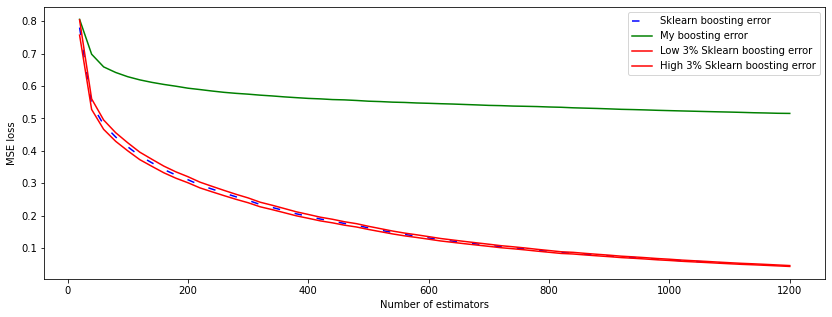

In [16]:
create_plot_MSE(X_train,y_train,X_train,y_train, 1200, 4, step = 20)

Как видно, с увеличиением глубины обливиос деревья начинают превосходить склерновский бустинг. На всех глубинах наблюдается более медленная сходимость у обливиос деревьев, чем у обычного бустинга, но они позволяют добиться лучших результатов. На трейне видно, что мсе обливиос деревьев драматически отличается от мсе обычного бустинга. Это может быть связано с тем, что обливиос деревья избегают переобучения.